IMPORTING THE NECESSARY LIBRARIES

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
%matplotlib inline
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.metrics import accuracy_score

IMPORTING AND HAVING A LOOK INTO THE DATA

In [2]:
data = "http://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data"
columns = ["class", "leftweight", "leftdistance", "rightweight", "rightdistance"]
df_balance = pd.read_csv(data)
df_balance.columns = columns
df_balance.head()

,class,leftweight,leftdistance,rightweight,rightdistance
0,R,1,1,1,2
1,R,1,1,1,3
2,R,1,1,1,4
3,R,1,1,1,5
4,R,1,1,2,1


## Train Test Split

FUNCTION FOR SPLITTING THE DATA INTO TRAINING AND TESTING SET

In [0]:
def train_test_split(X, y=None, split_ratio=0.3, random_state=123, stype="separate"):
  np.random.seed(random_state)
  if stype=="separate":
    split = np.random.rand(X.shape[0]) < split_ratio
    return X[~split], X[split], y[~split], y[split]
  elif stype=="whole":
    split = np.random.rand(X.shape[0]) < split_ratio
    return X[~split], X[split] 

FUNCTION TO FIND THE CORRELATED FEATURES AND REMOVE THOSE HAVING CORRELATION VALUE GREATER THAN A CERTAIN THRESHOLD

In [0]:
# >> FEATURE Handling << #
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped

In [0]:
def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped


![alt text](https://drive.google.com/uc?id=1CjZXVClvg1UQzcB_44JjA2frUsCln_8l)

In [0]:
# >> MODEL TRAINING << #
def compute_cost(W, X, Y):
    # calculate hinge loss
    N = X.shape[0]
    distances = 1 - Y * (np.dot(X, W))
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge_loss = regularization_strength * (np.sum(distances) / N)

    # calculate cost
    cost = 1 / 2 * np.dot(W, W) + hinge_loss
    return cost

In [0]:
# vanilla and mini-batch gradient descent 
def calculate_cost_gradient(W, X_batch, Y_batch):
    # if only one example is passed (eg. in case of SGD)
    if type(Y_batch) == np.float64:
        Y_batch = np.array([Y_batch])
        X_batch = np.array([X_batch])  # gives multidimensional array

    distance = 1 - (Y_batch * np.dot(X_batch, W))
    dw = np.zeros(len(W))

    for ind, d in enumerate(distance):
        if max(0, d) == 0:
            di = W
        else:
            di = W - (regularization_strength * Y_batch[ind] * X_batch[ind])
        dw += di

    dw = dw/len(Y_batch)  # average
    return dw

In [0]:
def sgd(features, outputs):
    max_epochs = 5000
    weights = np.zeros(features.shape[1])
    nth = 0
    prev_cost = float("inf")
    cost_threshold = 0.01  # in percent
    # stochastic gradient descent
    for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
            ascent = calculate_cost_gradient(weights, x, Y[ind])
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^nth epoch
        if epoch == 2 ** nth or epoch == max_epochs - 1:
            cost = compute_cost(weights, features, outputs)
            print("Epoch is: {} and Cost is: {}".format(epoch, cost))
            # stoppage criterion
            if abs(prev_cost - cost) < cost_threshold * prev_cost:
                return weights
            prev_cost = cost
            nth += 1
    return weights

In [0]:
def init():
    print("reading dataset...")
    # train the model
    print("training started...")
    W = sgd(X_train.to_numpy(), y_train.to_numpy())
    print("training finished.")
    print("weights are: {}".format(W))

    # testing the model
    print("testing the model...")
    y_train_predicted = np.array([])
    for i in range(X_train.shape[0]):
        yp = np.sign(np.dot(X_train.to_numpy()[i], W))
        y_train_predicted = np.append(y_train_predicted, yp)

    y_test_predicted = np.array([])
    for i in range(X_test.shape[0]):
        yp = np.sign(np.dot(X_test.to_numpy()[i], W))
        y_test_predicted = np.append(y_test_predicted, yp)

    print("accuracy on test dataset: {}".format(accuracy_score(y_test, y_test_predicted)))


In [0]:
X = df_balance.iloc[:, 1:]
y = df_balance["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
data = df_balance
# convert categorical labels to numbers
diag_map = {'R': 1.0, 'L': -1.0,'B': 0.0} #mapping of 3 classes
data['class'] = data['class'].map(diag_map)

# put features & outputs in different data frames
X = df_balance.iloc[:, 1:]
Y = df_balance["class"]

# filter features if required
'''
remove_correlated_features(X)
remove_less_significant_features(X, Y)

# normalize data for better convergence and to prevent overflow
X_normalized = MinMaxScaler().fit_transform(X.values)
X = pd.DataFrame(X_normalized)

# insert 1 in every row for intercept b
X.insert(loc=len(X.columns), column='intercept', value=1)
'''
# split data into train and test set
print("splitting dataset into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, Y)
print(X_train.head(5))

splitting dataset into train and test sets...
   leftweight  leftdistance  rightweight  rightdistance
0           1             1            1              2
3           1             1            1              5
4           1             1            2              1
5           1             1            2              2
6           1             1            2              3


In [12]:
# set hyper-parameters and call init
regularization_strength = 10000
learning_rate = 0.00001
init()

reading dataset...
training started...
Epoch is: 1 and Cost is: 4575.9353547963
Epoch is: 2 and Cost is: 2927.7502457916726
Epoch is: 4 and Cost is: 4595.255615361734
Epoch is: 8 and Cost is: 3229.8958593572684
Epoch is: 16 and Cost is: 3189.6141965063875
Epoch is: 32 and Cost is: 2574.885268433476
Epoch is: 64 and Cost is: 2426.7952718226957
Epoch is: 128 and Cost is: 2408.3071884751803
training finished.
weights are: [-5.15879553 -5.26966757  5.44174204  5.52199984]
testing the model...
accuracy on test dataset: 0.8707865168539326


### Sklearn Model

In [13]:
sk_svc = svm.SVC()
sk_svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
y_pred = sk_svc.predict(X_test)
print ("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  89.8876404494382


VISUALIZING THE DATA

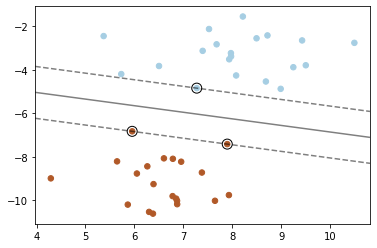

In [15]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)


# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()